In [ ]:
%matplotlib widget
from bmcs_cross_section.api import MKappa, EC2, ACI440, AnaFRPBending, ReinfLayer
import bmcs_utils.api as bu 
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

bu.set_latex_mpl_format()
plot_colors = bu.plot_colors

# Deriving the two-lines equations

Using a linear regression on data based on the parabolic EC2 stress-strain law of concrete

In [ ]:
# EC2, eq. (3.14)

sig_c1, sig_c2, sig_c3, eps_cu1, b, d, A_f, f_fu, E_f, rho_f, sigma_f = \
 sp.symbols(r'\sigma_c1 \sigma_c2 \sigma_c3, \varepsilon_\mathrm{cu1}, b, d, A_\mathrm{f}, f_\mathrm{fu}, E_\mathrm{f}, \rho_\mathrm{f}, \sigma_\mathrm{f}', real=True, nonnegative=True)
eps_cy, eps_cu, eps, E_cc, f_cm, eps_1 = \
sp.symbols(r'\varepsilon_\mathrm{cy}, \varepsilon_\mathrm{cu}, \varepsilon, E_\mathrm{cc}, f_\mathrm{cm}, \varepsilon_\mathrm{1}', real=True, nonnegative=True)
kappa= sp.symbols(r'\kappa', real=True)

k = 1.05 * E_cc * eps_cy / f_cm
eta = eps / eps_cy
sig_c = f_cm * (k * eta - eta**2)/(1 + eta*(k-2))

sig_c_eps_ = sp.Piecewise(
        (0, eps > eps_cu),
        (sig_c, eps > 0),
        (0, True)
)

In [ ]:
# # Comparison to EC2, multi-linear concept

# result2 = np.zeros((len(f_cms), 3))

# for i, f_cm_ in enumerate(f_cms):
#     sig_c_eps = sig_c_eps_.subs({E_cc:EC2.get_E_cm(f_cm_ - 8), eps_cy:eps_cy_, 
#                                 f_cm:EC2.get_f_cm(f_cm_ - 8), eps_cu:EC2.get_eps_cu1(f_cm_- 8)})
#     get_sig = sp.lambdify(eps, sig_c_eps, 'numpy')
#     eps_exact = np.linspace(0, eps_cy_, 300)
#     sig_exact = get_sig(eps_exact)
#     area_fine = np.trapz(y=sig_exact, x=eps_exact)
    
#     f_ck = f_cm_ - 8
#     eps_c3 = EC2.get_eps_c3(f_ck)
#     eps_cu3 = EC2.get_eps_cu3(f_ck)
#     area = eps_c3 * f_cm_ / 2 + (eps_cu3 - eps_c3) * f_cm_
    
#     result2[i, 0] = f_cm_
#     result2[i, 1] = area_fine
#     result2[i, 2] = area
# result2

In [ ]:
# f_cms = np.array([ 20.,  24.,  28.,  33.,  38.,  43.,  48.,  53.,  58.,  63.,  68., 78.,  88.,  98., 108.])
f_cms = np.linspace(20, 108, 108 -20 +1)
result = np.zeros((len(f_cms), 3))

f_cm_limit = 98

for i, f_cm_ in enumerate(f_cms):
    eps_cy_ = EC2.get_eps_c1(f_cm_ - 8)
    eps_cu_ = EC2.get_eps_cu1(f_cm_- 8)

    sig_c_eps = sig_c_eps_.subs({E_cc:EC2.get_E_cm(f_cm_ - 8), eps_cy:eps_cy_, 
                                f_cm:EC2.get_f_cm(f_cm_ - 8), eps_cu:eps_cu_})
    get_sig = sp.lambdify(eps, sig_c_eps, 'numpy')
    
    eps_exact_part_1 = np.linspace(0, eps_cy_, 300)
    sig_exact_part_1 = get_sig(eps_exact_part_1)
    area_exact_part_1 = np.trapz(y=sig_exact_part_1, x=eps_exact_part_1)
    
    eps_exact_part_2 = np.linspace(eps_cy_, eps_cu_, 300)
    sig_exact_part_2 = get_sig(eps_exact_part_2)
    area_exact_part_2 = np.trapz(y=sig_exact_part_2, x=eps_exact_part_2)
    
    print('area_exact_part_2=', area_exact_part_2)

    sig_eps_c1_new = 2 * area_exact_part_1 / eps_cy_
    sig_eps_c1_scale = sig_eps_c1_new / f_cm_
    
    sig_eps_cu1_new = 2 * area_exact_part_2 / (eps_cu_ - eps_cy_) - sig_eps_c1_new
    sig_eps_cu1_scale = sig_eps_c1_scale if f_cm_ >= f_cm_limit else sig_eps_cu1_new / f_cm_
    
    result[i] = [f_cm_, sig_eps_c1_scale, sig_eps_cu1_scale]

result

In [ ]:
fig1, ax1 = plt.subplots()
ax1.plot(result[:, 0], result[:, 1])
ax1.plot(result[:, 0], result[:, 2])

In [ ]:
# Linear regression using numpy

m1, p1 = np.polyfit(result[:, 0], result[:, 1], 1)
sig_cy_scale = m1 * f_cm + p1

# Exclude f_cm >= f_cm_limit from curve fitting
f_cms_less_than_limit = result[:, 0][result[:, 0] < f_cm_limit]
sig_eps_cu1_scale_for_f_cms_less_than_limit = result[:, 2][result[:, 0] < f_cm_limit]
m2, p2 = np.polyfit(f_cms_less_than_limit, sig_eps_cu1_scale_for_f_cms_less_than_limit, 1)
sig_cu_scale = m2 * f_cm + p2

sig_cy_scale, sig_cu_scale

In [ ]:
get_sig_cy_scale = sp.lambdify(f_cm, sig_cy_scale, 'numpy')
get_sig_cu_scale = sp.lambdify(f_cm, sig_cu_scale, 'numpy')

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_xlabel('$f_\mathrm{cm}$ [MPa]')
ax1.set_ylabel('$\lambda_\mathrm{cy},\;\lambda_\mathrm{cu}$ [-]')

# ax1.plot(result[:, 0], result[:, 1], '--', label='$\lambda_\mathrm{cy}$ exact', color=plot_colors[0])
ax1.plot(result[:, 0], result[:, 1], 'o', markersize=3, label='$\lambda_\mathrm{cy}$ exact', color=plot_colors[0])
ax1.plot(result[:, 0], get_sig_cy_scale(result[:, 0]), label='$\lambda_\mathrm{cy}$ fitted', color=plot_colors[0])

# ax1.plot(result[:, 0], result[:, 2], '--', label='$\lambda_\mathrm{cu}$ exact', color=plot_colors[1])
ax1.plot(result[:, 0], result[:, 2], 'o', markersize=3, label='$\lambda_\mathrm{cu}$ exact', color=plot_colors[1])
ax1.plot(result[:, 0], get_sig_cu_scale(result[:, 0]), label='$\lambda_\mathrm{cu}$ fitted', color=plot_colors[1])

ax1.legend()
fig1.show()

In [ ]:
# fig1.savefig('f_cm_vs_sigma_cy_scale_sigma_cu_scale.pdf')

In [ ]:
# Just for checking..

fig, ax = plt.subplots()

for f_cm_ in [60]: # f_cms:
    eps_cy_ = EC2.get_eps_c1(f_cm_ - 8)
    eps_cu_ = EC2.get_eps_cu1(f_cm_ - 8)
    sig_c_eps = sig_c_eps_.subs({E_cc:EC2.get_E_cm(f_cm_ - 8), eps_cy:eps_cy_, 
                                f_cm:f_cm_, eps_cu:eps_cu_})
    get_sig = sp.lambdify(eps, sig_c_eps, 'numpy')
    
    eps_exact = np.linspace(0, eps_cu_, 300)
    sig_exact = get_sig(eps_exact)
    
    sigma_cm_cy_scale = result[np.argwhere(result[:, 0] == f_cm_)[0]][0][1]
    sigma_cm_cu_scale = result[np.argwhere(result[:, 0] == f_cm_)[0]][0][2]
    eps_coarse = np.array([0., eps_cy_, eps_cu_])
    sig_coarse = np.array([0., f_cm_ * sigma_cm_cy_scale, f_cm_ * sigma_cm_cu_scale])
    
    area_approx = np.trapz(y=sig_coarse, x=eps_coarse)
    area_exact = np.trapz(y=sig_exact, x=eps_exact)
    print('area_approx =', area_approx)
    print('area_exact =', area_exact)
    print('area_diff [%] =', (area_exact - area_approx) * 100 / area_exact)
    
    ax.fill_between(eps_coarse, sig_coarse, color= 'orange', alpha= 0.1)
    ax.fill_between(eps_exact, sig_exact, color= 'blue', alpha= 0.1)
    ax.set_xlabel('Concrete strain')
    ax.set_ylabel('Concrete stress')
    ax.plot(eps_exact, sig_exact)
    ax.plot(eps_coarse, sig_coarse)
    
    # Plot example lines
    eps_sig_coarse_equals_f_cm = np.interp(f_cm_, sig_coarse[:-1], eps_coarse[:-1])
    eps_coarse_psi = np.array([0, eps_sig_coarse_equals_f_cm, eps_cu_])
    sig_coarse_psi = np.array([0, f_cm_, f_cm_])
    eps_example = 0.001
    sig_example = np.interp(eps_example, eps_coarse, sig_coarse)
    
    ax.plot(eps_coarse_psi, sig_coarse_psi, label='$\psi_c$ assumption, $\psi_c = red/black$')
    ax.plot([eps_example, eps_example], [0, sig_example])
    ax.plot([eps_cy_, eps_cy_], [0, f_cm_], c='black')
    ax.legend()

fig.show()

In [ ]:
# fig.savefig('stress_strain_concrete_curve_with_linear_approx.pdf')

# Deriving $M_u, \rho_\mathrm{fb}, \psi_c, \psi_f$ equations for the 2-lines-based material law

In [ ]:
substitute_eps_cy = False
substitute_scaled_stress = False

if substitute_eps_cy:
    eps_cy = 0.001 * sp.Min(0.7 * f_cm ** 0.31, 2.8) # 0.001 * 0.7 * f_cm ** 0.31
    eps_cu = 0.001 * sp.Piecewise(
        (3.5, f_cm <= 58), 
        (2.8 + 27 * ((98 - f_cm) / 100) ** 4, True)
)
    
# Don't substitute scaled_stress as it makes formulas longer and not any better!
if substitute_scaled_stress:
    sig_cy_scaled = f_cm * sig_cy_scale
    sig_cu_scaled = f_cm * sig_cu_scale
else:
    sig_cy_scaled, sig_cu_scaled = sp.symbols(r'\sigma_\mathrm{cy}, \sigma_\mathrm{cu}')

sig_line = sp.Line(sp.Point(0, 0), sp.Point(eps_cy, sig_cy_scaled))
sig_line2 = sp.Line(sp.Point(eps_cy, sig_cy_scaled), sp.Point(eps_cu, sig_cu_scaled))

sig_eq_1 = sig_line.equation(x=eps, y=sig_c1)
sig_eq1 = sp.solve(sig_eq_1, sig_c1)[0]

sig_eq_2 = sig_line2.equation(x=eps, y=sig_c2)
sig_eq2 = sp.solve(sig_eq_2, sig_c2)[0]

In [ ]:
sig_eq = sp.Piecewise(
        (sig_eq1, eps <= eps_cy), 
        (sig_eq2, True)
)
sig_eq

In [ ]:
sig_eq_area = sp.integrate(sp.simplify(sig_eq), eps)
sig_eq_area

In [ ]:
# sp.simplify(sig_eq_area).subs({eps_cu - eps_cy: d_eps})

In [ ]:
area_up_to_eps_part_1 = sig_eq_area.args[0][0]
area_up_to_eps_part_2 = sig_eq_area.args[1][0]

## Calculate $F_\mathrm{c, cy}$ and $\rho_\mathrm{f, cy}$ defining the switch from part 1 to 2

In [ ]:
# Compare F_t = A_f * f_fu with F_c_cy, if F_t <= F_c_1, then use psi_c formula, otherwise psi_c = 1
# Note: one can also compare eps_top_solved with eps_cy, but the equation of eps_top_solved is more complicated
eps_fu = f_fu/E_f
c_1 = d * (eps_cy / (eps_cy + eps_fu))
F_c_cy = area_up_to_eps_part_1.subs({eps:eps_cy}) * (c_1 / eps_cy) * b
F_c_cy = sp.simplify(F_c_cy)
F_c_cy

In [ ]:
# rho corresponding to concrete block up to eps_cy
F_t_cy = A_f * f_fu
A_f_cy = sp.solve(F_c_cy - F_t_cy, A_f)[0]
rho_f_cy = A_f_cy /(b*d)
rho_f_cy

In [ ]:
sp.print_latex(rho_f_cy)

### Final $\rho_\mathrm{f, cy}$ formula

$\rho_\mathrm{f, cy} = \frac{E_\mathrm{f} \sigma_\mathrm{cy} \varepsilon_\mathrm{cy}}{2 f_\mathrm{fu} \left(E_\mathrm{f} \varepsilon_\mathrm{cy} + f_\mathrm{fu}\right)}$

## $\psi_c$ for part 1

In [ ]:
# Solving eps top for part 1
def get_eps_top_solved(index):
    c = d * eps/(eps + eps_fu)
    F_t = A_f * f_fu
    area_up_to_eps = area_up_to_eps_part_1 if index == 0 else area_up_to_eps_part_2
    sig_z_area = area_up_to_eps * (c / eps)
    F_c = sig_z_area * b
    eps_top_solved = sp.solve(F_t - F_c, eps)[1] # Note: this the positive solution
    eps_top_solved = sp.simplify(eps_top_solved)
    return eps_top_solved

eps_part_1 = get_eps_top_solved(0)
eps_part_1

In [ ]:
eps_part_1

In [ ]:
# Solving eps top for part 1
def get_psi(index):
    if index > 0:
        return 1
    else:
        eps_top_solved = get_eps_top_solved(0)
        sig_c_max = sig_eq1.subs({eps: eps_top_solved})
        # Variant 1:
#         psi_c = sp.Min(sig_c_max / f_cm, 1)
        # Variant 2: has larger error compared to upper variant, but it doesn't yield 1 until eps_c=eps_cy
        psi_c = sig_c_max / sig_cy_scaled
        psi_c = sp.simplify(psi_c)
        return psi_c
psi_c = get_psi(0)
psi_c

### Validate with data

In [ ]:
sigma_cy_cu_vals = {sig_cy_scaled:f_cm * sig_cy_scale, sig_cu_scaled:f_cm * sig_cu_scale}
test_vals= {f_cm:50, b:400, d:180, f_fu:2500, E_f:200000, 
            A_f:20,
            E_cc:EC2.get_E_cm(50-8), 
            eps_cy:EC2.get_eps_c1(50-8),
           eps_cu:EC2.get_eps_cu1(50-8)}

In [ ]:
sp.N(psi_c.subs(sigma_cy_cu_vals).subs(test_vals))

### Validate with Test T1

In [ ]:
T1_data = {f_cm:98.63, b:300, d:90, f_fu:3823.90, E_f:247468.92, \
           rho_f:28.96/(300 * 90),
           A_f:28.96, E_cc:EC2.get_E_cm(98.63-8), eps_cy:EC2.get_eps_c1(98.63-8), \
           eps_cu:EC2.get_eps_cu1(98.63-8)}

# Value from MK tool is about 0.77
sp.N(psi_c.subs(sigma_cy_cu_vals).subs(T1_data))

### Reduce and print formula

In [ ]:
psi_c_reduced = sp.cse(psi_c)
psi_c_reduced[-1][0]

In [ ]:
sp.print_latex(psi_c_reduced[-1][0])

In [ ]:
psi_c_reduced[0][0][1]

### Final $\psi_c$ formula

For $\rho_\mathrm{f} < \rho_\mathrm{fb}$, the utilization ratio for concrete is given as

$
\psi_c = \min\left(1,~\frac{f_\mathrm{fu}}{b d f_\mathrm{cm}} \cdot \bigg( A_\mathrm{f} + \sqrt{\frac{A_\mathrm{f} \cdot (A_\mathrm{f} E_\mathrm{f} \varepsilon_{cy} + 2 b d f_\mathrm{cm, cy})}{E_\mathrm{f} \varepsilon_\mathrm{cy}}} \bigg)\right)
$

Note: can be used for $\rho_\mathrm{f} < \rho_\mathrm{fb}$ without checking $F_t < F_{c, cy}$ because for that case it indeed result in a value larger than 1, so the final resulting value of 1 is correct.

## $M_u$ for part 1

In [ ]:
# Because first part is triangle, the center of it is
# ce: the distance from the top of the cross section to the centroid of concrete compression block
eps_f = sigma_f / E_f
c = d * eps/(eps + eps_f)
c1 = c.subs({eps: eps_part_1, sigma_f: f_fu})
ce1 = c1 / 3
ce1 = sp.simplify(ce1)
ce1

In [ ]:
# sp.simplify(c1).subs({x4: 'm2'})

In [ ]:
# Valid for f_cm > 80 in general and in case F_t < F_c_1
M_n_1 = sp.simplify(A_f * f_fu * (d - ce1))
M_n_1

### Reduce and print formula

In [ ]:
# packaging common terms
M_n_1_reduced = sp.cse(M_n_1)
M_n_1_reduced

In [ ]:
M_n_1_reduced[-1][0]

In [ ]:
symb_exp_list = [[s, e] for (s, e) in M_n_1_reduced[0]]
for symb_exp in symb_exp_list:
    symb_exp[1] = symb_exp[1].subs({s:e for (s, e) in symb_exp_list})
symb_exp_list

In [ ]:
x2 = symb_exp_list[2][1]
x2

In [ ]:
sp.print_latex(x2)

In [ ]:
x4 = symb_exp_list[4][1]
x4

In [ ]:
sp.print_latex(x4)

In [ ]:
sp.print_latex(M_n_1_reduced[-1][0])

### Final $M_u$ formula

For $\rho_\mathrm{f} < \rho_\mathrm{f, cy}$, flexural capacity is given

$M_\mathrm{u,cy} = \frac{A_\mathrm{f} d f_\mathrm{fu} \left(3 m_{1} + 2 m_{2}\right)}{3 \left(m_{1} + m_{2}\right)}$

with

\begin{align}
m_1 & = \sqrt{E_\mathrm{f}} b d f_\mathrm{cm, cy}, \\
m_2 & =  E_f \Bigg( \sqrt{A_\mathrm{f} \varepsilon_\mathrm{cy} \cdot \bigg(A_\mathrm{f} E_\mathrm{f} \varepsilon_\mathrm{cy} + \frac{2 m_1}{\sqrt{E_\mathrm{f}}}\bigg)} + A_\mathrm{f}~\varepsilon_\mathrm{cy}~\sqrt{E_\mathrm{f}} \Bigg)
\end{align}

## Curvature $\kappa$ for part 1

Valid for $\rho_f < \rho_{f, cy}$

In [ ]:
kappa_1 = eps_part_1 / c1
kappa_1

In [ ]:
# or as follows
kappa_1 = kappa_1.subs({eps_part_1: eps_1})
kappa_1

## Solving for the second part where $\varepsilon_c < \varepsilon_{cu}$

Note: this is complex and not usable, but left here for completeness, use the formula of $\rho_f > \rho_{fb}$ instead which gives conservative M_u solution.

In [ ]:
# eps_part_2 = get_eps_top_solved(1)
# eps_part_2

In [ ]:
# ce_part_2 = ce2_eps_fraction.subs({eps: eps_part_2}) * c.subs({eps: eps_part_2})
# # simplify takes forever here
# # ce_part_2 = sp.simplify(ce_part_2)
# ce_part_2

In [ ]:
# M_n_part_2 = A_f * f_fu * (d - ce_part_2)
# # simplify takes forever here
# # M_n_part_2 = sp.simplify(M_n_part_2)
# M_n_part_2

# Deriving $M_u$ and other equations for $\rho_\mathrm{f} \ge \rho_\mathrm{fb}$

Here, we know that $\varepsilon_{c, top} = \varepsilon_{cu}$

## Balanced reinforcement ratio $\rho_\mathrm{fb}$

In [ ]:
F_t = A_f * f_fu
sig_z_area = area_up_to_eps_part_2.subs({eps:eps_cu}) * (c.subs({eps:eps_cu}) / eps_cu)
F_c = sig_z_area * b
A_fb = sp.solve(F_t - F_c, A_f)[0]
A_fb = sp.simplify(A_fb).subs(sigma_f, f_fu)
rho_fb = A_fb / (b * d)
rho_fb

In [ ]:
# This should be almost 0.00326 according to MK tool
sp.N(rho_fb.subs(sigma_cy_cu_vals).subs(test_vals))

## $M_\mathrm{u}$ for $\rho_\mathrm{f} > \rho_\mathrm{fb}$

In [ ]:
# Calculating centroid and area for second part:
# -----------------------------------------------
# The following is valid for any eps in the second descending line in the approximated sig-eps relation
# For f_cm > f_cm_limit, only the triangle is enough as the trapz doesn't exist because eps_cy = eps_cu
# However, even if these are used, setting eps_cy = eps_cu would cancel the trapezoidal part.
# Therefore, eps_cu1 formula in EC2 was adapted below.

triangle_area = eps_cy * sig_cy_scaled / 2
triangle_ce = (eps - eps_cy) + eps_cy / 3

small_base_trapz = sig_eq.args[1][0]
large_base_trapz = sig_cy_scaled
h_trapz = eps - eps_cy
trapz_ce_dist_from_large_base = (h_trapz/3) * (large_base_trapz + 2 * small_base_trapz) / (large_base_trapz + small_base_trapz)
trapz_ce_dist_from_large_base = sp.simplify(trapz_ce_dist_from_large_base)
trapz_ce = eps - eps_cy - trapz_ce_dist_from_large_base
trapz_ce = sp.simplify(trapz_ce)
trapz_area = h_trapz * (small_base_trapz + large_base_trapz) / 2 
trapz_area = sp.simplify(trapz_area)

total_area = triangle_area + trapz_area

ce2_eps = ((trapz_ce * trapz_area) + (triangle_ce * triangle_area)) / total_area
ce2_eps_fraction = ce2_eps / eps
ce2_eps_fraction = sp.simplify(ce2_eps_fraction)
ce2_eps_fraction

In [ ]:
# ce: the distance from the top of the cross section to the centroid of concrete compression block
eps_f = sigma_f / E_f
c = d * eps/(eps + eps_f)
c2 = c.subs({eps: eps_cu})
ce2 = ce2_eps_fraction.subs({eps: eps_cu}) * c2
ce2 = sp.simplify(ce2)
ce2

In [ ]:
F_t = A_f * sigma_f
sig_z_area = area_up_to_eps_part_2.subs({eps:eps_cu}) * (c.subs({eps:eps_cu}) / eps_cu)
F_c = sig_z_area * b
sigma_f_sol = sp.solve(F_t - F_c, sigma_f)[1].subs({A_f:rho_f * b * d})
sigma_f_sol = sp.simplify(sigma_f_sol)

# Note: if sigma_f > f_fu then FRP reinforcement will fail on tension (most probably a rho_f < rho_fb is used)
sigma_f_ = sp.Min(sigma_f_sol, f_fu)
sigma_f_

In [ ]:
psi_f = sigma_f / f_fu
psi_f

In [ ]:
test_vals= {f_cm:50, b:400, d:180, f_fu:2500, E_f:200000, 
            A_f:250, 
            rho_f:250/(180*400),
            E_cc:EC2.get_E_cm(50-8), 
            eps_cy:EC2.get_eps_c1(50-8),
           eps_cu:EC2.get_eps_cu1(50-8)}

In [ ]:
sp.N(sigma_f_.subs(sigma_cy_cu_vals).subs(test_vals))

In [ ]:
M_n_2 = A_f * sigma_f * (d - ce2)
M_n_2 = sp.simplify(M_n_2)
M_n_2

# for rho<rho_fb but F_t > F_c_cy, a conservative approx is to USE THIS TOO, but with replacing sigma_f with f_fu ;)
# even if sigma_f is used it will retrun f_fu as it's limited not to exceed it

### Validation with Mk model


M_u_mk_model = 97.76 kNm

M_u_model = 97.65 kNm !!!

M_u_aci = 81.72 kNm !!!

In [ ]:
sp.N(M_n_2.subs({sigma_f:sigma_f_}).subs(sigma_cy_cu_vals).subs(test_vals) / 1e6)

In [ ]:
ACI440.get_M_n(A_f=250, f_fu=2500, E_f=200000, f_c=50, b=400, d=180)

### Validation with T1 bending experiment

In [ ]:
sp.N(M_n_2.subs({sigma_f:sigma_f_}).subs(sigma_cy_cu_vals).subs(T1_data) / 1e6)

In [ ]:
ACI440.get_M_n(A_f=T1_data[A_f], f_fu=T1_data[f_fu], E_f=T1_data[E_f], f_c=T1_data[f_cm], b=T1_data[b], d=T1_data[d])

In [ ]:
sp.N(rho_fb.subs({sigma_f:sigma_f_}).subs(sigma_cy_cu_vals).subs(T1_data))

In [ ]:
ACI440.get_rho_balanced(f_c=T1_data[f_cm], f_fu=T1_data[f_fu], E_f=T1_data[E_f])

In [ ]:
fig, ax = plt.subplots()
rho_list = np.linspace(0.1/100, 2.5/100, 200)
A_f_list = rho_list * 200 * 280
get_M_n = sp.lambdify(A_f, M_n_2.subs({sigma_f:sigma_f_sol}).subs({rho_f:A_f/(b*d)}).subs(sigma_cy_cu_vals).subs({f_cm:48, b:200, d:280, f_fu:2500, E_f:158000, E_cc:EC2.get_E_cm(48-8), eps_cy:EC2.get_eps_c1(48-8), eps_cu:EC2.get_eps_cu1(48-8)}), 'numpy')

get_M_n_aci = np.zeros_like(rho_list)
for i, A_f_ in enumerate(A_f_list):
    get_M_n_aci[i] = ACI440.get_M_n(A_f=A_f_, f_fu=2500, E_f=158000, f_c=48, b=200, d=280)

ax.plot(rho_list, get_M_n(A_f_list)/1e6)
ax.plot(rho_list, get_M_n_aci, label='ACI')
ax.legend()

In [ ]:
ACI440.get_rho_balanced(f_c=48, f_fu=2500, E_f=158000)

In [ ]:
rho_fb.subs({sigma_f:sigma_f_sol, rho_f:A_f/(b*d)}).subs(sigma_cy_cu_vals).subs({f_cm:48, b:200, d:280, f_fu:2500, E_f:158000, E_cc:EC2.get_E_cm(48-8), eps_cy:EC2.get_eps_c1(48-8), eps_cu:EC2.get_eps_cu1(48-8)})

### Validation with experiments

**BC2HA** beam from Thériault1998_Effects of FRP Reinforcement Ratio and Concrete Strength on Flexural Behavior of Concrete Beams.pdf

M_u_experiment = 19.7 kNm

M_u_model = 19.7 kNm !!!

M_u_aci = 16 kNm !!!

In [ ]:
sp.N(M_n_2.subs({sigma_f:sigma_f_}).subs(sigma_cy_cu_vals).subs({f_cm:57.2, b:130, d:180-20-6-12.3/2, f_fu:773, E_f:38000,  rho_f:2*np.pi*(12.3/2)**2/(130*(180-20-6-12.3/2)), A_f:2*np.pi*(12.3/2)**2, E_cc:EC2.get_E_cm(57.2-8), eps_cy:EC2.get_eps_c1(57.2-8), eps_cu:EC2.get_eps_cu1(57.2-8)}) / 1e6)

In [ ]:
ACI440.get_M_n(A_f=2*np.pi*(12.3/2)**2, f_fu=773, E_f=38000, f_c=57.2, b=130, d=180-20-6-12.3/2)

### Reduce and print formula

In [ ]:
# packaging common terms
M_n_2_reduced = sp.cse(M_n_2)
M_n_2_reduced

In [ ]:
M_n_2_reduced[-1][0]

In [ ]:
symb_exp_list = [[s, e] for (s, e) in M_n_2_reduced[0]]
for symb_exp in symb_exp_list:
    symb_exp[1] = symb_exp[1].subs({s:e for (s, e) in symb_exp_list})
symb_exp_list

In [ ]:
d_eps = sp.symbols(r'\varepsilon_{\Delta}')
M_n_2_reduced_final = sp.simplify(M_n_2_reduced[-1][0].subs({sym: exp for sym, exp in symb_exp_list[:-1]}).subs({eps_cu - eps_cy: d_eps}))
M_n_2_reduced_final

In [ ]:
x5_final = sp.simplify(symb_exp_list[5][1].subs({eps_cu: d_eps + eps_cy}))
x5_final

In [ ]:
sp.simplify(M_n_2_reduced[-1][0].subs({sym: exp for sym, exp in symb_exp_list[:-1]}).subs({eps_cu - eps_cy: d_eps}))

In [ ]:
sp.print_latex(M_n_2_reduced_final)

In [ ]:
sp.print_latex(x5_final)

### Final $M_u$ formula

For $\rho_\mathrm{f} > \rho_\mathrm{f, cy}$, flexural capacity is given

$M_\mathrm{u,cu} = \frac{A_{f} d f_{f} 
\bigg(
3 m_0 \left(E_{f} \varepsilon_{cu} + f_{f}\right) 
- E_{f} \big(\Delta\varepsilon^2 \left(2 f_{cm_{cy}} + f_{cm_{cu}} \right)
~+~f_{cm_{cy}} \varepsilon_{cy} \left(3 \varepsilon_{cu} - 2 \varepsilon_{cy}\right)\big)\bigg)}
{3 m_0 \left(E_{f} \varepsilon_{cu} + f_{f}\right)}$

with

$m_0 = \Delta\varepsilon f_{cm_{cu}} + \Delta\varepsilon f_{cm_{cy}} + f_{cm_{cy}} \varepsilon_{cy}$

and

$\Delta\varepsilon = \varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy}$

<!-- \begin{align}
m_1 & = \sqrt{E_\mathrm{f}} b d f_\mathrm{cm, cy}, \\
m_2 & =  E_f \Bigg( \sqrt{A_\mathrm{f} \varepsilon_\mathrm{cy} \cdot \bigg(A_\mathrm{f} E_\mathrm{f} \varepsilon_\mathrm{cy} + \frac{2 m_1}{\sqrt{E_\mathrm{f}}}\bigg)} + A_\mathrm{f}~\varepsilon_\mathrm{cy}~\sqrt{E_\mathrm{f}} \Bigg)
\end{align} -->

Note: this formula is exact for $\rho_\mathrm{f} > \rho_\mathrm{fb}$, but for $\rho_\mathrm{f, cy} < \rho_\mathrm{f} < \rho_\mathrm{fb}$ it's a conservative approx. considering the whole concrete block which gives larger ce resulting in smaller M_u

## Ultimate curvature $\kappa$ for part 2 with $\varepsilon_c = \varepsilon_{cu}$ ($\rho_f \ge \rho_{fb}$)

Valid for $\rho_f \ge \rho_{fb}$

In [ ]:
kappa_2 = eps_cu / c2
kappa_2

In [ ]:
# From MK tool I get almost 8.75 * 1e-5
sp.N(kappa_2.subs({sigma_f:sigma_f_sol}).subs(sigma_cy_cu_vals).subs(test_vals))

## Ultimate curvature for $\rho_{f, cy} < \rho_f < \rho_{fb}$
A linear interpolation is done between k1 and k2

In [ ]:
kappa_1_symb, kappa_2_symb, rho_f_cy_symb, rho_fb_symb, kappa_u = sp.symbols(r'\kappa_\mathrm{u1}, \kappa_\mathrm{u2}, \rho_\mathrm{fcy}, \rho_\mathrm{fb}, \kappa_u', real=True, nonnegative=True)

kappa_u_cy_fb = sp.Line(sp.Point(rho_f_cy_symb, kappa_1_symb), sp.Point(rho_fb_symb, kappa_2_symb))
kappa_u_cy_fb_eq = kappa_u_cy_fb.equation(x=rho_f, y=kappa_u)
kappa_u_cy_fb_eq_sol = sp.simplify(sp.solve(kappa_u_cy_fb_eq, kappa_u)[0])
kappa_u_cy_fb_eq_sol

# Summary

## Moment capacity

Calculate $\rho_\mathrm{f,cy}$ as:

$
\rho_\mathrm{f,cy} = \frac{E_\mathrm{f} \sigma_\mathrm{cy} \varepsilon_\mathrm{cy}}{2 f_\mathrm{fu} \left(E_\mathrm{f} \varepsilon_\mathrm{cy} + f_\mathrm{fu}\right)}$

The ultimate flexural moment is given:

\begin{equation*}
  M_\mathrm{u}=
  \begin{cases}
      M_\mathrm{u,cy},
    & \rho_\mathrm{f} \le \rho_\mathrm{f,cy}\\
      M_\mathrm{u,cu},
    & \rho_\mathrm{f} > \rho_\mathrm{f,cy}.
  \end{cases}
\end{equation*}

### $M_\mathrm{u,cy}$

$M_\mathrm{u,cy} = \frac{A_\mathrm{f} d f_\mathrm{fu} \left(3 m_{1} + 2 m_{2}\right)}{3 \left(m_{1} + m_{2}\right)}$

with

\begin{align}
m_1 & = \sqrt{E_\mathrm{f}} b d \sigma_\mathrm{cy}, \\
m_2 & =  E_f \Bigg( \sqrt{A_\mathrm{f} \varepsilon_\mathrm{cy} \cdot \bigg(A_\mathrm{f} E_\mathrm{f} \varepsilon_\mathrm{cy} + \frac{2 m_1}{\sqrt{E_\mathrm{f}}}\bigg)} + A_\mathrm{f}~\varepsilon_\mathrm{cy}~\sqrt{E_\mathrm{f}} \Bigg), \\
\sigma_\mathrm{cy} & = 10^{-3} f_\mathrm{cm} \cdot (1437.6204 - 2.7858 f_\mathrm{cm})
\end{align}

and according to EC2

$\varepsilon_\mathrm{cy} = 0.001 \cdot \min\left(2.8,~0.7 f_\mathrm{cm}^{0.31}\right)$

In [ ]:
f_cm * sig_cy_scale

In [ ]:
sp.print_latex(sig_cy_scale * 1000)

### $M_\mathrm{u,cu}$
Note: this formula is exact for $\rho_\mathrm{f} > \rho_\mathrm{fb}$, but for $\rho_\mathrm{f, cy} < \rho_\mathrm{f} < \rho_\mathrm{fb}$ it's a conservative approx. considering the whole concrete block which gives larger $ce$ resulting in smaller M_u

$M_\mathrm{u,cu} = \frac{A_\mathrm{f} d \sigma_\mathrm{f} 
\bigg(
3 m_0 \left(E_\mathrm{f} \varepsilon_\mathrm{cu} + \sigma_\mathrm{f}\right) 
~ - ~E_\mathrm{f} \big(\Delta\varepsilon^2 \left(2 \sigma_\mathrm{cy} + \sigma_\mathrm{cu} \right)
~+~\sigma_\mathrm{cy} \varepsilon_\mathrm{cy} \left(3 \varepsilon_\mathrm{cu} - 2 \varepsilon_\mathrm{cy}\right)\big)\bigg)}
{3 m_0 \left(E_\mathrm{f} \varepsilon_\mathrm{cu} + \sigma_\mathrm{f}\right)}$

with

$\Delta\varepsilon = \varepsilon_\mathrm{cu} - \varepsilon_\mathrm{cy}$

and

$m_0 = \Delta\varepsilon \sigma_\mathrm{cu} + \Delta\varepsilon \sigma_\mathrm{cy} + \sigma_\mathrm{cy} \varepsilon_\mathrm{cy}$

$\sigma_\mathrm{f} = \min\left(f_\mathrm{fu},~0.5 \bigg( \sqrt{\frac{E_\mathrm{f} \cdot \big(E_\mathrm{f} \rho_\mathrm{f} \varepsilon_\mathrm{cu}^2~+~2 \sigma_\mathrm{cu} \Delta\varepsilon~+~2 \sigma_\mathrm{cy} \varepsilon_\mathrm{cu} \big)}
{\rho_\mathrm{f}}}
- E_{f} \varepsilon_\mathrm{cu}\bigg) \right)$

$\sigma_\mathrm{cu} = 10^{-3} f_\mathrm{cm} \cdot (8.2275 f_\mathrm{cm} + 95.5314)$

and

\begin{equation*}
  \varepsilon_\mathrm{cu}= 0.001 \cdot
  \begin{cases}
      3.5 ,
    & f_\mathrm{cm} \le 58~\mathrm{MPa} \\
    2.8 + 27 \cdot \big(\frac{98 - f_\mathrm{cm}}{100}\big)^4,
    & 58~\mathrm{MPa} < f_\mathrm{cm} \boldsymbol{\le 98~\mathrm{MPa}}\\
    \boldsymbol{2.8,}
    & \boldsymbol{f_\mathrm{cm} > 98~\mathrm{MPa}}.
  \end{cases}
\end{equation*}

The bold marked text is an adaptation to EC2 formula.

In [ ]:
f_cm * sig_cu_scale

In [ ]:
sp.print_latex(sig_cu_scale * 1000)

In [ ]:
sp.print_latex(rho_fb)

## Balanced reinforcement ratio $\rho_\mathrm{fb}$

$\rho_\mathrm{fb} = \frac{E_\mathrm{f} \left(\sigma_\mathrm{cu} \varepsilon_\mathrm{cu}~-~\sigma_\mathrm{cu} \varepsilon_\mathrm{cy}~+~\sigma_\mathrm{cy} \varepsilon_\mathrm{cu}\right)}{2 f_\mathrm{fu} \left(E_\mathrm{f} \varepsilon_\mathrm{cu}~+~f_\mathrm{fu}\right)}
$

## Material utilization factors ($\psi_\mathrm{c}~and~\psi_\mathrm{f}$)

\begin{equation*}
  \psi_\mathrm{c} =
  \begin{cases}
\min\left(
1,~
\frac{f_\mathrm{fu}}{f_\mathrm{cm}} \bigg(\rho_\mathrm{f} + \sqrt{\frac{\rho_\mathrm{f} \left(\rho_\mathrm{f} E_\mathrm{f} \varepsilon_{cy}~+~2 \sigma_\mathrm{cy}\right)}
{E_\mathrm{f} \varepsilon_\mathrm{cy}}} \bigg)\right)
,
    & \rho_\mathrm{f} < \rho_\mathrm{f,cy}\\
      1,
    & \rho_\mathrm{f} \ge \rho_\mathrm{f,cy}.
  \end{cases}
\end{equation*}


\begin{equation*}
  \psi_\mathrm{f} =
  \begin{cases}
      \frac{\sigma_\mathrm{f}}{f_\mathrm{fu}},
    & \rho_\mathrm{f} > \rho_\mathrm{fb}\\
      1,
    & \rho_\mathrm{f} \le \rho_\mathrm{fb}.
  \end{cases}
\end{equation*}

Notice that material utilization is optimal ($\psi_c = 1, \psi_f = 1$) for $\rho_\mathrm{f,cy} < \rho_\mathrm{f} < \rho_\mathrm{fb}$.

In [ ]:
sp.simplify(psi_c.args[1].subs({A_f:rho_f * b * d}))

# For a given $M_u$, solve for different parameters to get optimally utilized section

An optimally utilized section is a section with reinforcement ratio $\rho_\mathrm{f, cy} \le \rho \le \rho_\mathrm{fb}$

We substitute these limit reinforcement ratio in $M_n$ formula and solve for different parameters to find, for each parameter, a range that makes the section optimally utilized

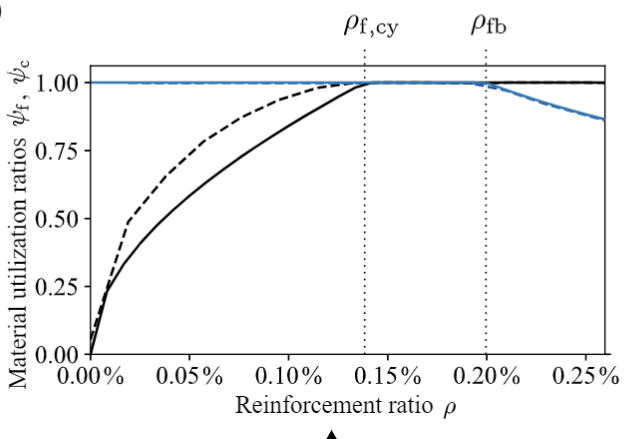

In [ ]:
M_req = sp.Symbol(r'M_\mathrm{req}')

In [ ]:
M_n_2_fb = M_n_2.subs(A_f, rho_fb * b * d).subs(sigma_f, f_fu)
M_n_2_cy = M_n_2.subs(A_f, rho_f_cy * b * d).subs(sigma_f, f_fu)

## $d$ range that ensures an optimal cross-section

Notice: if reinforcement ratio is higher then lower $d$ is needed, therefore $d$ corresponding to $\rho_\mathrm{fb}$ is the *min*

### Lower limit for $d$

In [ ]:
d_min = sp.simplify(sp.solve(M_n_2_fb - M_req, d)[1])
d_min

In [ ]:
sp.cse(d_min)

### Upper limit for $d$

In [ ]:
d_max = sp.simplify(sp.solve(M_n_2_cy - M_req, d)[1])
# or
# d_max = sp.solve(M_n_1.subs(A_f, rho_f_cy * b * d) - M_req, d)[1]
d_max

In [ ]:
sp.cse(d_max)[-1][0]

## $b$ range that ensures an optimal cross-section

### Lower limit for $b$

In [ ]:
b_min = sp.simplify(sp.solve(M_n_2_fb - M_req, b)[0])
b_min

In [ ]:
sp.cse(b_min)

### Upper limit for $b$

In [ ]:
b_max = sp.simplify(sp.solve(M_n_2_cy - M_req, b)[0])
# or
# b_max = sp.simplify(sp.solve(M_n_1.subs(A_f, rho_f_cy * b * d) - M_req, b)[0])
b_max

In [ ]:
sp.cse(b_max)

### Dimensionless efficient design diagram

#### Generalized diagrams

In [ ]:
from labellines import labelLine, labelLines

M_n_2_cy_norm = M_n_2_cy / (f_cm * b*d**2)
M_n_2_fb_norm = M_n_2_fb / (f_cm * b*d**2)

# f_cms = [30, 50, 90]
f_cms = [50]
f_fus = np.linspace(100, 5000, 60)
# E_fs = np.linspace(30000, 500000, 10)
E_fs = np.array([20, 30, 40, 50, 75, 100, 150, 200, 250, 300, 400, 500]) * 1000
M_n_2_cy_norm_vals = np.zeros((len(f_cms), len(E_fs), len(f_fus)))
M_n_2_fb_norm_vals = np.zeros((len(f_cms), len(E_fs), len(f_fus)))

for f_cm_i, f_cm_val in enumerate(f_cms):
    for E_j, E_f_val in enumerate(E_fs):
        for f_i, f_fu_val in enumerate(f_fus):
            t1_mat_params = {
                  f_cm:f_cm_val,
                  f_fu:f_fu_val, 
                  E_f:E_f_val, 
                  eps_cy:EC2.get_eps_c1(f_cm_val-8),
                  eps_cu:EC2.get_eps_cu1(f_cm_val-8) # In TTC model, this is adapted for f_cm > 98 to yield 0.0028
                 }
            M_n_2_cy_norm_vals[f_cm_i, E_j, f_i] = sp.N(M_n_2_cy_norm.subs(sigma_cy_cu_vals).subs(t1_mat_params))
            M_n_2_fb_norm_vals[f_cm_i, E_j, f_i] = sp.N(M_n_2_fb_norm.subs(sigma_cy_cu_vals).subs(t1_mat_params))

fig, axes = plt.subplots(len(f_cms), 2, figsize=(10, len(f_cms) * 6))

for f_cm_i, f_cm_val in enumerate(f_cms):
    ax1 = axes[f_cm_i, 0] if len(f_cms) > 1 else axes[0]
    ax2 = axes[f_cm_i, 1] if len(f_cms) > 1 else axes[1]
    ax1.set_xlabel(r'$M_{\rho_\mathrm{f, cy}}/(f_\mathrm{cm} bd^2)$')
    ax2.set_xlabel(r'$M_{\rho_\mathrm{fb}}/(f_\mathrm{cm} bd^2)$')
    title = r'$f_\mathrm{cm}$ = ' + str(f_cm_val)
    ax1.set_title(title); ax2.set_title(title)
    for i, E_f_val in enumerate(E_fs):
        label = r'$E_\mathrm{f} = $' + str(int(E_f_val/1000)) + ' GPa' if i==0 else str(round(E_f_val/1000))
        ax1.plot(M_n_2_cy_norm_vals[f_cm_i, i, :], f_fus, label=label)
        ax2.plot(M_n_2_fb_norm_vals[f_cm_i, i, :], f_fus, label=label)

for ax in axes.flatten():
    labelLines(ax.get_lines(), align=True, fontsize=14, zorder=12.5, yoffsets=0.1)
    ax.set_xlim(0, 0.5)
    ax.set_ylim(0, np.max(f_fus))
    ax.set_ylabel(r'$f_\mathrm{fu} \mathrm{[MPa]}$')
    ax.grid()
#     ax.legend()


#### Alternative approach

Given $b, M_\mathrm{req}$ calculate $d$ which gives a optimally utilized cross-section (have a reinf. ratio $\rho= \rho_\mathrm{fb}$)

In [ ]:
d_limit = d_min
get_d_sol = sp.lambdify((M_req, b, E_f, f_fu, f_cm, eps_cy, eps_cu), d_limit.subs(sigma_cy_cu_vals))

bs = np.linspace(20, 600, 50)
M_reqs = np.array([1, 5, 10, 20, 40, 80, 160]) * 1e6
bs_grid, M_reqs_grid = np.meshgrid(bs, M_reqs)

# t1_f_cm = 98.6
# t1_data = (M_reqs_grid, bs_grid, 247469, 3823.9, t1_f_cm, EC2.get_eps_c1(t1_f_cm-8), EC2.get_eps_cu1(t1_f_cm-8))
f_cm_val = 50
test_data = (M_reqs_grid, bs_grid, 200000, 1500, f_cm_val, EC2.get_eps_c1(f_cm_val-8), EC2.get_eps_cu1(f_cm_val-8))

ds_grid = get_d_sol(*test_data)

In [ ]:
fig1, ax1 = plt.subplots()

## Plotting b vs area too:
# get_A = sp.lambdify((b, d), b*d)
# A_grid = get_A(bs_grid, ds_grid)
# ax_A = ax1.twinx()
# ax_A.plot(bs_grid.T, A_grid.T * 1e-6, ls = 'dashed')

plots = ax1.plot(bs_grid.T, ds_grid.T, label=(M_reqs/1e6).astype(np.int_))
plots[-1].set_label(r'$M_\mathrm{req} = $' + str((M_reqs/1e6).astype(np.int_)[-1]) + ' kNm')

ax1.set_title('For given ' + r'$(f_\mathrm{cm}, f_\mathrm{fu}, E_\mathrm{f})$' + ' and ' + r' $\rho= \rho_\mathrm{fb}$')
ax1.set_xlabel(r'$b \mathrm{[mm]}$')
ax1.set_ylabel(r'$d \mathrm{[mm]}$')
ax1.grid()

labelLines(plots, align=True, fontsize=14, zorder=12.5, yoffsets=0.1);

In [ ]:
# Example design moment for a slab segment
q_d = 1.35 * 2.5 + 1.5 * 3
d_ribs = 0.6
Q_d = q_d * d_ribs
l = 6
M_d = Q_d * l**2 / 8
M_d

### Validation

In [ ]:
from bmcs_cross_section.api import AnaFRPBending
bend = AnaFRPBending(f_fu=3823.9, E_f=247469, f_cm=98.6, b=300, d=65)
bend.A_f = bend.rho_fb * bend.b * bend.d
bend.M_u

## Tests

In [ ]:
f_cm_val = 98.6
test_vals1 = {f_cm:f_cm_val, 
              b:300, 
              d:90, 
              f_fu:3823.9, 
              E_f:247469, 
#             A_f:250, 
#             rho_f:250/(180*400),
            E_cc:EC2.get_E_cm(f_cm_val-8), 
            eps_cy:EC2.get_eps_c1(f_cm_val-8),
           eps_cu:EC2.get_eps_cu1(f_cm_val-8)
             }
# test_vals1[d] = 185
# test_vals1[A_f] = rho_fb_test * test_vals1[b] * test_vals1[d]
# test_vals1[rho_f] = rho_fb_test
test_vals1

$b$ range

In [ ]:
sp.N(b_min.subs(sigma_cy_cu_vals).subs(test_vals1).subs(M_req, 100e6)) # with rho_fb

In [ ]:
sp.N(b_max.subs(sigma_cy_cu_vals).subs(test_vals1).subs(M_req, 100e6)) # with rho_f_cy

In [ ]:
rho_f_cy.subs(sigma_cy_cu_vals).subs(test_vals1)

In [ ]:
rho_fb.subs(sigma_cy_cu_vals).subs(test_vals1)

$d$ range

In [ ]:
sp.N(d_min.subs(sigma_cy_cu_vals).subs(test_vals1).subs(M_req, 100e6)) # with rho_fb

In [ ]:
sp.N(d_max.subs(sigma_cy_cu_vals).subs(test_vals1).subs(M_req, 100e6)) # with rho_f_cy

In [ ]:
rho_range = np.linspace(0.002057, 0.0032032, 50)
b_range = np.linspace(658.33585, 422.8495, 50)
d_range = np.linspace(230.9225, 185.069, 50)

In [ ]:
M_us = np.zeros_like(rho_range)
i = 0
for rho, b_val in zip(rho_range, b_range):
    M_u = AnaFRPBending(f_cm = 50, E_f = 200000, f_fu = 2500, b=b_val, d=180, A_f=rho * b_val * 180).M_u
    M_us[i] = M_u
    i += 1
M_us

In [ ]:
fig, ax = plt.subplots()
ax.plot(rho_range, M_us)

In [ ]:
M_us = np.zeros_like(rho_range)
i = 0
for rho, d_val in zip(rho_range, d_range):
    M_u = AnaFRPBending(f_cm = 50, E_f = 200000, f_fu = 2500, b=400, d=d_val, A_f=rho * 400 * d_val).M_u
    M_us[i] = M_u
    i += 1
M_us

In [ ]:
fig, ax = plt.subplots()
ax.plot(rho_range, M_us)

In [ ]:
rho_fb_test = sp.N(rho_fb.subs(sigma_cy_cu_vals).subs(test_vals1))
rho_fb_test